In [9]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler
import optuna

In [2]:
def normalize_features(df, continuous_features):
    scaler = StandardScaler()
    df[continuous_features] = scaler.fit_transform(df[continuous_features])
    return df, scaler

def one_hot_encode_features(df, categorical_features):
    dummies = pd.get_dummies(df[categorical_features], drop_first=True, dtype=float)
    df = df.join(dummies)
    return df

def compute_metrics(preds, targets):
    preds = preds.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    mae = np.mean(np.abs(preds - targets))
    rmse = np.sqrt(np.mean((preds - targets)**2))
    ss_res = np.sum((targets - preds)**2)
    ss_tot = np.sum((targets - np.mean(targets))**2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else 0.0
    return mae, rmse, r2

def assign_game_index(df):
    # If your dataset contains a unique GAME-ID column, use it. Otherwise, use TEAM and DATE.
    if 'GAME-ID' in df.columns:
        unique_games = df[['TEAM', 'GAME-ID', 'DATE']].drop_duplicates().sort_values(by=['TEAM', 'DATE'])
        unique_games['game_index'] = unique_games.groupby('TEAM').cumcount()
        # Merge back the game_index onto the original DataFrame
        df = df.merge(unique_games[['TEAM', 'GAME-ID', 'game_index']], on=['TEAM', 'GAME-ID'], how='left')
    else:
        unique_games = df[['TEAM', 'DATE']].drop_duplicates().sort_values(by=['TEAM', 'DATE'])
        unique_games['game_index'] = unique_games.groupby('TEAM').cumcount()
        df = df.merge(unique_games[['TEAM', 'DATE', 'game_index']], on=['TEAM', 'DATE'], how='left')
    return df





In [4]:
# load csvs
df = pd.read_excel(r'live_data/03-19-2025-mlb-season-player-feed.xlsx', skiprows=[0])
#df2 = pd.read_excel(r"../historical_data/MLB-2024-Player-BoxScore-Dataset.xlsx", skiprows=[0])
dfs = [df]

batter_features = ['game_index', 'DATE', 'PLAYER', 'TEAM',
                    'VENUE', 'OPPONENT','AB', 'R', 'H', 'RBI',
                    'BB', 'SO', 'next_target_H', "PLAYER-ID",
                    'next_target_H', "PLAYER-ID", 'VENUE_Road',
                    'opp_starting_pitcher', 'HAND_R']
continuous_batter = ['AB', 'R', 'H', 'RBI', 'BB', 'SO']

pitcher_features = ['game_index', 'DATE', 'PLAYER', 'TEAM',
                    'VENUE', 'OPPONENT', 'IP', 'H.1', 'R.1',
                    'ER', 'ERA', 'BB.1', 'SO.1', 'next_target_SO',
                    "PLAYER-ID", 'VENUE_Road', 'HAND.1_R']
continuous_pitcher = ['IP', 'H.1', 'R.1', 'ER', 'ERA', 'BB.1', 'SO.1']

categorical_batter = ['VENUE', 'HAND']
categorical_pitcher = ['VENUE','HAND.1']

In [33]:
def clean_and_split(df, inference=False):
    df.columns = df.columns.str.strip().str.replace('"', '')

    # Flag pitchers and set targets
    df['is_pitcher'] = df['STARTING\nPITCHER'].notnull()
    df['target_SO'] = df.apply(lambda row: row["SO.1"] if row['is_pitcher'] else row["SO"], axis=1)
    df['target_H']  = df.apply(lambda row: row["H.1"] if row['is_pitcher'] else row["H"], axis=1)

    # Offset targets per player so current game features predict next game outcomes
    if not inference:
        df.sort_values(["PLAYER-ID", "DATE"], inplace=True)
        df["next_target_SO"] = df.groupby("PLAYER-ID")["target_SO"].shift(-1)
        df["next_target_H"]  = df.groupby("PLAYER-ID")["target_H"].shift(-1)
        df = df.dropna(subset=["next_target_SO", "next_target_H"])

    # -----------------------------
    # 2. Split into Pitchers and Batters
    # -----------------------------
    pitchers_df = df[df['is_pitcher']].copy()
    display(df[df['is_pitcher']])
    batters_df = df[~df['is_pitcher']].copy()

    return pitchers_df, batters_df


In [34]:
def normalize_and_index(pitchers_df, batters_df):
    pitchers_df['DATE'] = pd.to_datetime(pitchers_df['DATE'])
    pitchers_df = assign_game_index(pitchers_df)

    batters_df['DATE'] = pd.to_datetime(batters_df['DATE'])
    batters_df = assign_game_index(batters_df)

    # normalize numerical features
    batters_df, batter_scaler = normalize_features(batters_df, continuous_batter)
    pitchers_df, pitcher_scaler = normalize_features(pitchers_df, continuous_pitcher)

    # one-hot encode categorical features
    batters_df = one_hot_encode_features(batters_df, categorical_batter)
    pitchers_df = one_hot_encode_features(pitchers_df, categorical_pitcher)

    # save sklearn scalers
    torch.save(batter_scaler, "batter_scaler.pt")
    torch.save(pitcher_scaler, "pitcher_scaler.pt")

    return pitchers_df, batters_df

In [35]:
def align_opps(pitchers_df, batters_df):
    # Create a subset of the pitcher DataFrame with only the relevant columns.
    # We assume 'TEAM' in pitchers_df is the pitcher's team and that each row is a starting pitcher.
    # Rename the 'PLAYER-ID' column to something like 'opp_starting_pitcher' to clarify its role.
    pitcher_lookup = pitchers_df[['GAME-ID', 'TEAM', 'DATE', 'PLAYER-ID']].copy()
    pitcher_lookup = pitcher_lookup.rename(columns={
        'TEAM': 'opp_team', 
        'PLAYER-ID': 'opp_starting_pitcher'
    })

    # Merge batter_df with pitcher_lookup based on the batter's opponent and the game date.
    # This will add a new column 'opp_starting_pitcher' to batters_df.
    batters_df = batters_df.merge(
        pitcher_lookup[['opp_team', 'DATE', 'opp_starting_pitcher']], 
        left_on=['OPPONENT', 'DATE'], 
        right_on=['opp_team', 'DATE'], 
        how='left'
    )

    # Optionally, drop the extra 'opp_team' column if you don't need it.
    batters_df.drop(columns=['opp_team'], inplace=True)
    batters_df['opp_starting_pitcher'].fillna(0, inplace=True)
    batters_df['opp_starting_pitcher'] = batters_df['opp_starting_pitcher'].astype(int)
    return pitchers_df, batters_df


In [36]:
# pipeline these functions
def preprocess(df):
    pitchers_df, batters_df = clean_and_split(df)
    pitchers_df, batters_df = normalize_and_index(pitchers_df, batters_df)
    pitchers_df, batters_df = align_opps(pitchers_df, batters_df)
    return pitchers_df, batters_df


In [ ]:
pitcher_dfs = []
batter_dfs = []
for df in dfs:
    pitcher_df, batter_df = preprocess(df)
    pitcher_dfs.append(pitcher_df)
    batter_dfs.append(batter_df)

pitchers_df = pd.concat(pitcher_dfs)
batters_df = pd.concat(batter_dfs)

In [153]:
batters_df[batter_features].dropna().shape

(135848, 19)

In [154]:
pitchers_df[pitcher_features].dropna().shape

(9399, 17)

In [150]:
batters_df[batter_features].dropna().to_csv("train_batters.csv")
pitchers_df[pitcher_features].dropna().to_csv("train_pitchers.csv")

In [3]:
pitcher_df = pd.read_csv("../data/train_pitchers_ema.csv")
batter_df = pd.read_csv("../data/train_batters_ema.csv")

In [4]:
pitcher_df.head()

,Unnamed: 0,game_index,DATE,PLAYER,TEAM,VENUE,OPPONENT,IP,H.1,R.1,...,PLAYER-ID,VENUE_Road,HAND.1_R,IP_ema,H.1_ema,R.1_ema,ER_ema,ERA_ema,BB.1_ema,SO.1_ema
0,0,33,2023-05-06,Adam Wainwright,St. Louis Cardinals,Home,Detroit Tigers,-0.030559,1.303045,0.631828,...,425794,0.0,1.0,-0.030559,1.303045,0.631828,0.726529,1.237823,-1.289822,0.050014
1,1,38,2023-05-12,Adam Wainwright,St. Louis Cardinals,Road,Boston Red Sox,-0.030559,0.869005,0.631828,...,425794,1.0,1.0,-0.030559,1.158365,0.631828,0.726529,1.237823,-0.791237,-0.343323
2,2,44,2023-05-18,Adam Wainwright,St. Louis Cardinals,Home,Los Angeles Dodgers,0.101839,0.000923,1.111719,...,425794,0.0,1.0,0.013574,0.772551,0.791792,0.396205,1.021715,-0.209555,-0.736661
3,3,49,2023-05-23,Adam Wainwright,St. Louis Cardinals,Road,Cincinnati Reds,0.101839,1.303045,1.111719,...,425794,1.0,1.0,0.042995,0.949382,0.898434,0.671475,0.964975,-0.320351,-0.867773
4,4,55,2023-05-29,Adam Wainwright,St. Louis Cardinals,Home,Kansas City Royals,-0.030559,1.737086,0.151937,...,425794,0.0,1.0,0.018477,1.211950,0.649602,0.524664,0.900504,-0.144923,-0.430732


In [65]:
# train xgb model to predict strikeouts from pitcher features
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# define features and target
features = ['IP', 'H.1', 'R.1', 'ER', 'ERA', 'BB.1', 'SO.1']
target = 'next_target_SO'

# split data
X = pitcher_df.drop(['Unnamed: 0', 'next_target_SO', 'DATE', 'PLAYER', 'TEAM', 'VENUE', 'OPPONENT', 'PLAYER-ID'], axis=1)
y = pitcher_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit model
model = XGBRegressor()
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

# evaluate model
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2: {r2}")



Root Mean Squared Error: 2.63570224911885
Mean Absolute Error: 2.0885938587757025
R^2: 0.06537621188406584


In [68]:
def objective(trial):
    params = {
        'device': 'gpu',
        'booster': 'gbtree',
        # Center around best found
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 75, 150),
        'enable_categorical': True,
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'gamma': trial.suggest_float('gamma', 0.3, 0.7),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 1.5),
        'enable_categorical': True,
        # Additional, e.g. for dart booster
        # 'rate_drop': trial.suggest_float('rate_drop', 0.0, 0.3),
        # 'skip_drop': trial.suggest_float('skip_drop', 0.0, 0.3),
        # Try different objective if relevant (poisson, etc.)
        'objective': 'count:poisson',
    }
    
    
    accuracies = []
    
    
    model = XGBRegressor(**params)
    model.fit(X_train, y_train,
                eval_set=[(X_test, y_test)],
                verbose=False)
        
    preds = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=225)

print("Best hyperparams:", study.best_params)


[I 2025-03-22 14:50:25,569] A new study created in memory with name: no-name-a8ad6f37-e125-4be4-95f7-45502584194d
[I 2025-03-22 14:50:27,308] Trial 0 finished with value: 2.4920296588636845 and parameters: {'max_depth': 4, 'learning_rate': 0.16346917935411476, 'n_estimators': 150, 'min_child_weight': 1, 'gamma': 0.6513400367261901, 'subsample': 0.7457716875472177, 'colsample_bytree': 0.9858863244380536, 'reg_alpha': 0.31064273153850713, 'reg_lambda': 0.9256053978678132}. Best is trial 0 with value: 2.4920296588636845.
[I 2025-03-22 14:50:28,365] Trial 1 finished with value: 2.476998006301471 and parameters: {'max_depth': 3, 'learning_rate': 0.1994301137148884, 'n_estimators': 123, 'min_child_weight': 3, 'gamma': 0.6938568120330612, 'subsample': 0.8298685527125736, 'colsample_bytree': 0.8592696596903332, 'reg_alpha': 0.3856644419084564, 'reg_lambda': 0.7401972271142269}. Best is trial 1 with value: 2.476998006301471.
[I 2025-03-22 14:50:29,768] Trial 2 finished with value: 2.47739780519

Best hyperparams: {'max_depth': 4, 'learning_rate': 0.10605376318659018, 'n_estimators': 123, 'min_child_weight': 5, 'gamma': 0.517741838698711, 'subsample': 0.9344407713443548, 'colsample_bytree': 0.9158611718321598, 'reg_alpha': 0.45779397759118456, 'reg_lambda': 0.9153508602234467}


In [69]:
# train model with best params
params = study.best_params
print(params)
model = XGBRegressor(**params)
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

# evaluate model
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2: {r2}")

{'max_depth': 4, 'learning_rate': 0.10605376318659018, 'n_estimators': 123, 'min_child_weight': 5, 'gamma': 0.517741838698711, 'subsample': 0.9344407713443548, 'colsample_bytree': 0.9158611718321598, 'reg_alpha': 0.45779397759118456, 'reg_lambda': 0.9153508602234467}
Root Mean Squared Error: 2.488906948670583
Mean Absolute Error: 1.9736124854038242
R^2: 0.1665847239563728


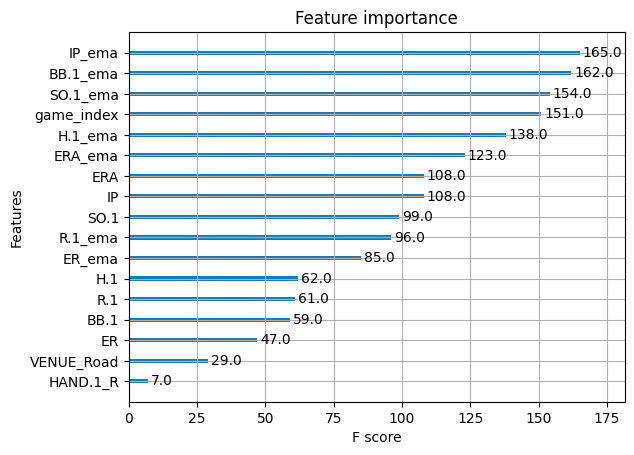

In [70]:
# plot feature importance
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(model)
plt.show()

In [ ]:
# fit autogloun model to predict strikeouts from pitcher features

from autogluon.tabular import TabularPredictor

# define features and target
target = 'next_target_SO'

# split data
X = pitcher_df.drop(['Unnamed: 0', 'next_target_SO', 'DATE', 'PLAYER', 'TEAM', 'VENUE', 'OPPONENT', 'PLAYER-ID'], axis=1)
y = pitcher_df[target]

train_data = pd.concat([X, y], axis=1)
train_data = train_data.dropna()
train_data = train_data.reset_index(drop=True)

# fit model
predictor = TabularPredictor(label=target, problem_type='regression', eval_metric='r2').fit(train_data,  presets='experimental')

# evaluate model
results = predictor.evaluate(train_data)
print(results)



No path specified. Models will be saved in: "AutogluonModels\ag-20250323_165643"
Preset alias specified: 'experimental' maps to 'experimental_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
Memory Avail:       35.92 GB / 63.83 GB (56.3%)
Disk Space Avail:   667.60 GB / 952.62 GB (70.1%)
Presets specified: ['experimental']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value